In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [116]:
def W_pred(X_new):
    
    mu_X = [151.74736042]
    sigma_X = [34.94415798]
    B = [[1.89453211, 3.1580302,  4.58156681]]
    A = [ 9.93866667, 20.08833333, 37.43866667]
    X_new_scaled = (X_new - mu_X) / sigma_X
    Y_scaled_pred_direct = X_new_scaled @ B  
    Y_pred_direct = Y_scaled_pred_direct + A 
    
    return Y_pred_direct

def L_pred(X_new):
    
    mu_X = [201.78218686, 736.3733133 ]
    sigma_X = [ 91.934371,   239.33190586]
    B = [[30.47983386, 56.41028485, 84.9595095 ], [32.95049616, 60.98284141, 91.84623527]]
    A = [138.22833333, 290.32783333, 434.75716667]
    X_new_scaled = (X_new - mu_X) / sigma_X
    Y_scaled_pred_direct = X_new_scaled @ B  
    Y_pred_direct = Y_scaled_pred_direct + A 
    
    return Y_pred_direct

def smoother(LLL,T1,LX,k):
    
    T = [np.mean([ j for j in LLL.iloc[i:i+k,LX] ]) for i in range(len(LLL)-k)]
    t = np.linspace(min(T1),max(T1),len(T)).reshape(1,-1)

    return t[0], np.array(T).reshape(1,-1)[0]

def data_preprocess(E1,k):

    T1 = (E1['Time']).values.reshape(1,-1)[0] - (E1['Time'][0:1]).values[0]
    WWW_1 = pd.DataFrame(W_pred(np.array([E1[['OPC R: W10 ','OPC R: W50 ','OPC R: W90 ']].iloc[:,DESC_best_W]]))[0][:,:])
    LLL_1 = pd.DataFrame(L_pred(np.array([E1[['OPC R: L10 ','OPC R: L50 ','OPC R: L90 ']].iloc[:,DESC_best]]))[0][:,:])
    SL1 = [smoother(LLL_1,T1,2,k)[0],smoother(LLL_1,T1,0,k)[1],smoother(LLL_1,T1,1,k)[1],smoother(LLL_1,T1,2,k)[1]]
    SW1 = [smoother(WWW_1,T1,2,k)[0],smoother(WWW_1,T1,0,k)[1],smoother(WWW_1,T1,1,k)[1],smoother(WWW_1,T1,2,k)[1]]
    
    return T1, WWW_1, LLL_1, SL1, SW1

def solub(T):
    return (0.000011181*(T**2) + 0.0004036447*T + 0.0368389481)

def plotter(fig, axT, E1, T1, WWW_1, LLL_1, SL1, SW1, finaltime,j, collor='blue'):
    
    axT[0,0].plot(T1,E1['H01:External T'],'black',linestyle='-',alpha=0.5)
    ax_FBRM = axT[0,0].twinx()
    ax_FBRM.plot(T1,E1['OPC R: Counts '],collor,linestyle='-',alpha=0.7)
    axT[0,0].set_xlabel(E1.columns[0][0]+' '+'['+E1.columns[0][1]+']')
    axT[0,0].set_ylabel(E1.columns[2][0]+' '+'['+E1.columns[2][1]+']')
    ax_FBRM.set_ylabel(E1.columns[4][0]+' '+'['+E1.columns[4][1]+']')
    axT[0,0].grid(True)
    ax_FBRM.set_ylim([0,80000])
    
    axT[0,1].plot(T1,E1['H01:External T'],'black',linestyle='-',alpha=0.5)
    ax_conc = axT[0,1].twinx()
    ax_conc.scatter(T1,E1['File R: Conc '],c=collor,s=4,alpha=0.7)
    ax_conc.plot(T1,solub(E1['H01:External T']))
    axT[0,1].set_xlabel(E1.columns[0][0]+' '+'['+E1.columns[0][1]+']')
    axT[0,1].set_ylabel(E1.columns[2][0]+' '+'['+E1.columns[2][1]+']')
    ax_conc.set_ylabel(E1.columns[-1][0]+' '+'['+E1.columns[-1][1]+']')
    ax_conc.set_ylim([0.04,0.08])
    axT[0,1].grid(True)

    mask = (T1 > max(T1) - finaltime)
    
    axT[1,0].plot(T1,E1['H01:External T'],'black',linestyle='-',alpha=0.2)
    ax_L = axT[1,0].twinx()
    ax_L.plot(T1,LLL_1,collor,linestyle='-',alpha=0.1)
    ax_L.plot(T1[mask],LLL_1.iloc[mask,:],collor,linestyle='-',alpha=0.6)    
    [ax_L.plot(SL1[0],SL1[i],collor, linestyle='-',alpha=0.9) for i in [1,2,3]]
    axT[1,0].set_xlabel(E1.columns[0][0]+' '+'['+E1.columns[0][1]+']')
    axT[1,0].set_ylabel(E1.columns[2][0]+' '+'['+E1.columns[2][1]+']')
    ax_L.set_ylim([0,300])
    ax_L.set_ylabel('Length'+' '+'['+E1.columns[5][1]+']')
    axT[1,0].grid(True)
    
    ax_L.text(plt.xlim()[1]*(0.3+j*0.25),plt.ylim()[1]*1.01,f'Exp. no:{j : .0f}', color=collor)
    
    axT[1,1].plot(T1,E1['H01:External T'],'black',linestyle='-',alpha=0.5)
    ax_W = axT[1,1].twinx()
    ax_W.plot(T1,WWW_1,collor,linestyle='-',alpha=0.3)
    ax_W.plot(T1[mask],WWW_1.iloc[mask,:],collor,linestyle='-',alpha=0.9)    
    [ax_W.plot(SW1[0],SW1[i],collor, linestyle='-',alpha=0.9) for i in [1,2,3]]
    axT[1,1].set_xlabel(E1.columns[0][0]+' '+'['+E1.columns[0][1]+']')
    axT[1,1].set_ylabel(E1.columns[2][0]+' '+'['+E1.columns[2][1]+']')
    ax_W.set_ylabel('Width'+' '+'['+E1.columns[9][1]+']')
    axT[1,1].grid(True)
    ax_W.set_ylim([0,30])
    fig.tight_layout()
    
    pass

def final_value(T1, WWW_1,finaltime):
    mask = (T1 > max(T1) - finaltime)
    return np.mean(WWW_1[mask][:],0)

def SED(L,W):
    return ((6*L*(W**2))/np.pi)**(1/3)

def evaluator(LOCS,colorrs,fig,axT,res):
    for j,i in enumerate(LOCS):
        E1 = pd.read_csv(i, header = [0, 1])
            
        T1, WWW_1, LLL_1, SL1, SW1 = data_preprocess(E1,100)
                
        plotter(fig, axT, E1,T1, WWW_1, LLL_1, SL1, SW1, finaltime,j, collor=colorrs[j%3])
        VAL = pd.DataFrame({'Length':final_value(T1, WWW_1, finaltime),'Width': final_value(T1, LLL_1, finaltime), 'SED': SED(final_value(T1, LLL_1, finaltime),final_value(T1, WWW_1, finaltime))})        
        res.append(VAL)
    return res
    

In [112]:
loc1 = r"D:\1. Doktori\1. Aktív projktek\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\6. Purdue\1. Sandia - Resveratrol Data\New_omnibus\Re_ repr_Omni_1126\expttsd2.csv"
loc2 = r"D:\1. Doktori\1. Aktív projktek\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\6. Purdue\1. Sandia - Resveratrol Data\New_omnibus\Re_ repr_Omni_1126\expttsd4.csv"
loc3 = r"D:\1. Doktori\1. Aktív projktek\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\6. Purdue\1. Sandia - Resveratrol Data\New_omnibus\Re_ repr_Omni_1126\expttsd6.csv"
loc4 = r"D:\1. Doktori\1. Aktív projktek\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\6. Purdue\1. Sandia - Resveratrol Data\New_omnibus\repr_Omni_1126\expttsd2.csv"
loc5 = r"D:\1. Doktori\1. Aktív projktek\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\6. Purdue\1. Sandia - Resveratrol Data\New_omnibus\repr_Omni_1126\expttsd4.csv"

DESC_best_W = [2]
DESC_best =   [1, 2]

finaltime = 10 # minutes
colorrs = ['blue','red','green']


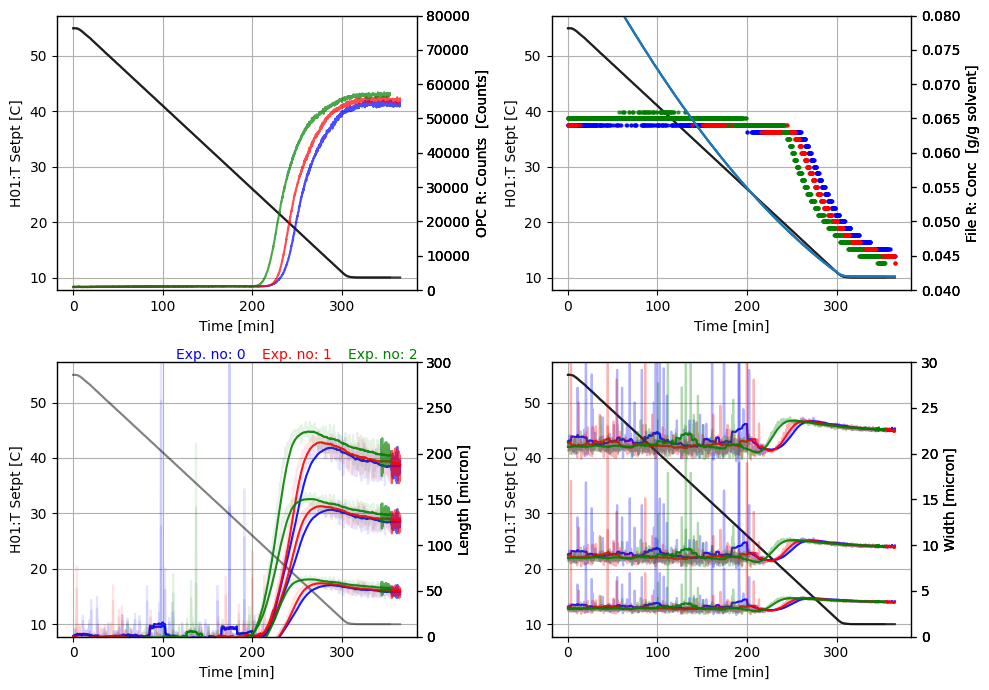

In [114]:
LOCS1 = [loc1, loc2, loc3]
fig, axT = plt.subplots(2,2,figsize=(10,7))
res = []
R = evaluator(LOCS1,colorrs,fig,axT,res)

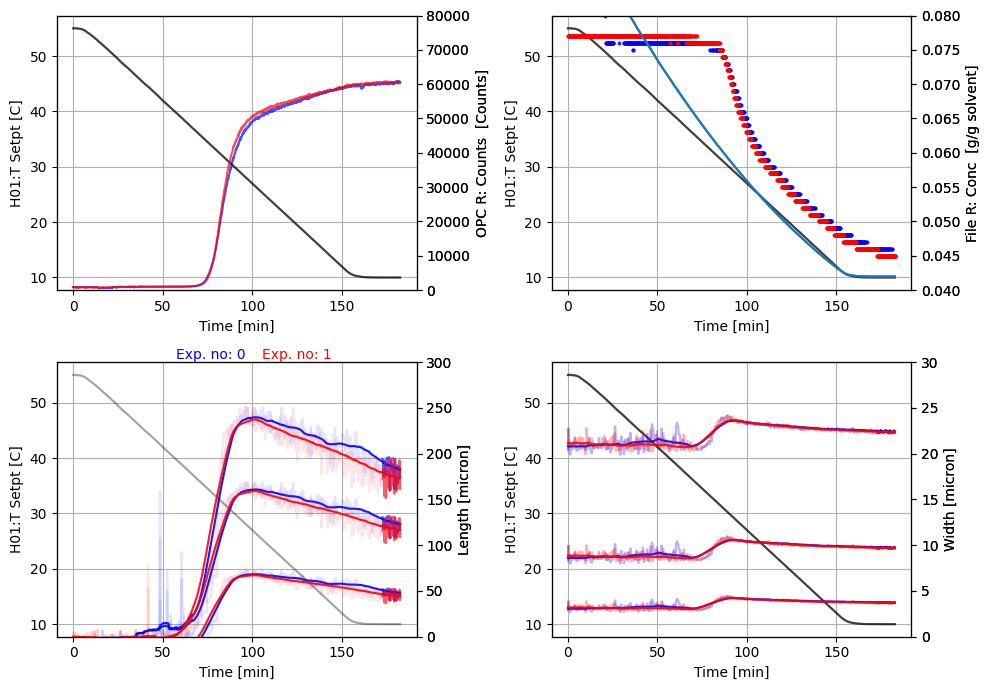

In [115]:
LOCS2 = [loc4, loc5]
fig, axT = plt.subplots(2,2,figsize=(10,7))
res = []
RR = evaluator(LOCS2,colorrs,fig, axT,res)